In [11]:
import pandas as pd
df = pd.read_csv("ab_test.csv") #import the dataset

### Exploratory Data Analysis

In [12]:
df.head() # Display the first few rows of the DataFrame


,id,time,group,page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


From the first 5 rows, it can be seen that the control group was shown the old page while the treatment group was shown the new page. 

In [13]:
df.info() # Check column types and nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         294478 non-null  int64 
 1   time       294478 non-null  object
 2   group      294478 non-null  object
 3   page       294478 non-null  object
 4   converted  294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


The number of customers used were 294478, and there were no missing entry in the dataset.

In [14]:
df.isnull().sum() # Check for missing values 

id           0
time         0
group        0
page         0
converted    0
dtype: int64

In [15]:
df.duplicated().sum() # Check for duplicate rows


np.int64(0)

There are no duplicate rows. 

In [16]:
df['group'].value_counts() # count the number of users in each group

group
treatment    147276
control      147202
Name: count, dtype: int64

The treatment and control groups are nearly equal in size. This balance supports a fair comparison between the two groups in the A/B test.

<Axes: xlabel='group'>

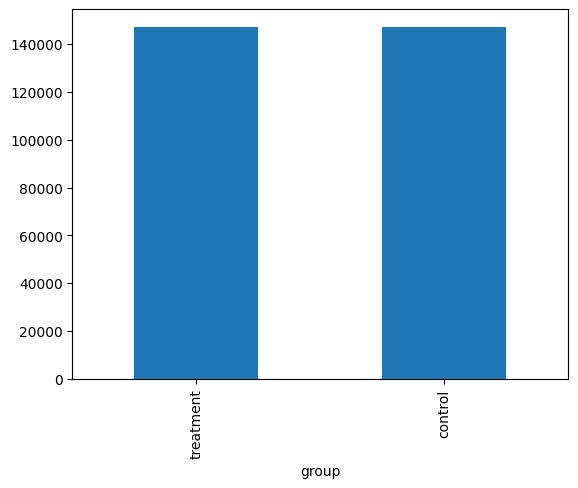

In [17]:

df['group'].value_counts().plot(kind='bar') # Visualize the distribution of groups


<Axes: xlabel='group', ylabel='count'>

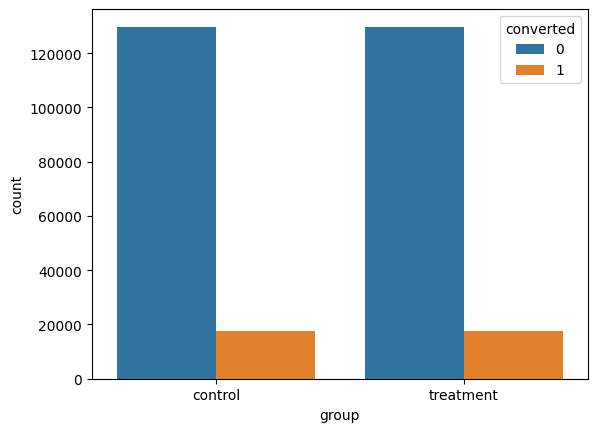

In [18]:
import seaborn as sns
sns.countplot(data=df, x='group', hue='converted') # Countplot of conversion by group


In [19]:
df.groupby('group')['converted'].mean() # Calculate conversion rate by group


group
control      0.120399
treatment    0.118920
Name: converted, dtype: float64

The control group has a slightly higher conversion rate (12.04%) compared to the treatment group (11.89%), suggesting a small difference in performance.

In [20]:
df.groupby(['group', 'page']).size() # Check for mismatched page views in each group

group      page    
control    new_page      1928
           old_page    145274
treatment  new_page    145311
           old_page      1965
dtype: int64


- **1,928 users** in the **control group** saw the **new_page** (they should have seen old_page)
- **1,965 users** in the **treatment group** saw the **old_page** (they should have seen new_page)
- This gives a total of **3,893 mismatched users**

These mismatches can **bias the results** of the experiment and must be removed before proceeding with the A/B test analysis.

The dataset needs to be filtered to keep only:
- Control group users who saw `old_page`
- Treatment group users who saw `new_page`


<Axes: xlabel='converted'>

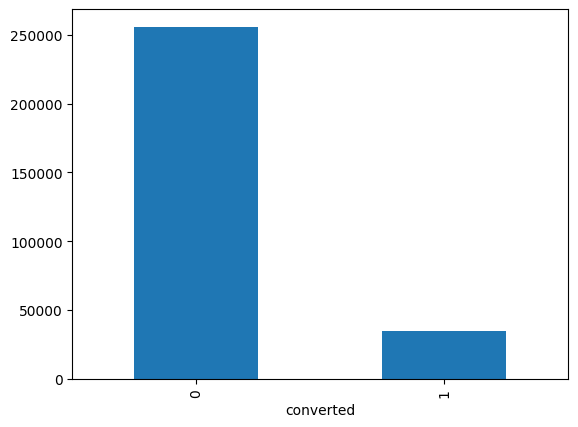

In [21]:
# Keep only correct group-page pairs
clean_df = df[((df['group'] == 'control') & (df['page'] == 'old_page')) |
              ((df['group'] == 'treatment') & (df['page'] == 'new_page'))]
clean_df['converted'].value_counts().plot(kind='bar')

In [22]:
summary = clean_df.groupby("group")["converted"].agg(["count", "sum"])
summary["conversion_rate"] = summary["sum"] / summary["count"]
print(summary)


            count    sum  conversion_rate
group                                    
control    145274  17489         0.120386
treatment  145311  17264         0.118807


In the cleaned data,the control group  has a slightly higher conversion rate (12.04%) compared to the treatment group (11.88%), suggesting a small difference in performance. Further testing is needed to determine if this difference is statistically significant.

### A/B TESTING

A/B testing is a statistical method used to compare two versions of a webpage, product, or feature to determine which one performs better. In this case, users were randomly assigned to either a **control group** (old page) or a **treatment group** (new page), and we compare their conversion rates.

To evaluate whether the observed difference in conversion rates is statistically meaningful, we will use a **two-proportion z-test**. This test is appropriate because we're comparing the proportions of conversions (successes) between **two independent groups**.



We then calculate the **p-value** to decide whether to reject the null hypothesis.




#### Hypotheses

**Null hypothesis (H₀):**  
There is **no difference** in conversion rates between the control and treatment groups.  
In other words, the new page does **not** perform better or worse than the old page.

**Alternative hypothesis (H₁):**  
There **is a difference** in conversion rates between the control and treatment groups.  
This means the new page either performs **better or worse** than the old page.


#### Decision Rule

We will use a significance level of **α = 0.05**.

- If the **p-value < 0.05**:  
  🔹 We **reject the null hypothesis** and conclude that there is a **statistically significant difference** in conversion rates between the control and treatment groups.

- If the **p-value ≥ 0.05**:  
  🔹 We **fail to reject the null hypothesis** and conclude that any difference in conversion rates is likely due to **random chance**.


In [26]:
from statsmodels.stats.proportion import proportions_ztest

success = summary["sum"].tolist() # Number of conversions in each group
nobs = summary["count"].tolist()  # Total users in each group
z_stat, p_val = proportions_ztest(success, nobs)
print(f"Z-stat: {z_stat:.4f}, P-value: {p_val:.4f}")

if p_val < 0.05:
    print("Reject the null hypothesis: There is a significant difference in conversion rates.")
else:
    print("Fail to reject the null hypothesis: No significant difference in conversion rates.")

Z-stat: 1.3116, P-value: 0.1897
Fail to reject the null hypothesis: No significant difference in conversion rates.


#### 📌 Recommendation:
There is **no strong evidence** that the new page performs better than the existing one.  
Therefore, it's recommended to **keep the current version of the page** for now.

The company may consider:
- Running the test longer (if underpowered)
- Testing a more impactful design change in future iterations